In [1]:
%load_ext autoreload
%autoreload
%matplotlib widget
from N_xi_fit_funcs import *
import phaseco as pc
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import correlate, get_window, convolve, correlation_lags
from scipy.optimize import curve_fit
import os


In [2]:
# Directories
os.chdir(r"C:\Users\setht\Dropbox\Citadel\GitHub\phase-coherence")
pkl_folder = r"C:\Users\setht\Dropbox\Citadel\GitHub\phase-coherence\paper_analysis\pickles"

In [3]:
# Get waveform
wf_idx = 2
species = "Owl"
wf_len_s = 1
wf, wf_fn, fs, good_peak_freqs, bad_peak_freqs = get_wf(
    species=species,
    wf_idx=wf_idx,
)
wf = crop_wf(wf, fs, wf_len_s)
f0 = good_peak_freqs[1]

In [10]:
# Get colossogram
win_type = 'flattop'
win_meth = {'method':'static', 'win_type':win_type}
bw = 200
pw =  True
tau = get_precalc_tau_from_bw(bw, fs, win_type, pkl_folder)
nfft = tau
hop = 1
xis = {
    'xi_min_s':0.001,
    'xi_max_s':0.1,
    'delta_xi_s':0.001
}
f0s = [f0]
cgram_dict = load_calc_colossogram(
    **{
        "wf": wf,
        "wf_idx": wf_idx,
        "wf_fn": wf_fn,
        "wf_len_s": wf_len_s,
        "wf_pp": None,
        "species": species,
        "fs": fs,
        "filter_meth": None,
        "pkl_folder": pkl_folder,
        "pw": pw,
        "tau": tau,
        "nfft": nfft,
        "xi_min_s": xis['xi_min_s'],
        "xi_max_s": xis['xi_max_s'],
        "hop": hop,
        "win_meth": win_meth,
        "force_recalc_colossogram": 0,
        "plot_what_we_got": 0,
        "only_calc_new_coherences": 0,
        "const_N_pd": 1,
        "scale": True,
        "N_bs": 0,
        "f0s": f0s,
        "demean":False,
    }
)
f = cgram_dict['f']
f0_exact = f[np.argmin(np.abs(f-f0))]

Processing 'C:\Users\setht\Dropbox\Citadel\GitHub\phase-coherence\paper_analysis\pickles\Owl 2, PW=True, Static Flattop, hop=1, tau=821, filter=None, xi_max=100ms, nfft=821, f0s=[8096], wf_len=1s, wf=TAG6rearSOAEwf1 (Colossogram).pkl'


100%|██████████| 100/100 [02:47<00:00,  1.67s/it]


In [11]:
"Plot colosogram"
# pc.plot_colossogram(cgram_dict['xis_s'], cgram_dict['f'], cgram_dict['colossogram'])
# plt.xlim(None, 20)
# plt.ylim(3, 12)

'Plot colosogram'

In [12]:
"Get single narrowband around f0"
win = get_window(win_type, tau)
omega_0_norm = f0_exact * 2*np.pi / fs
n = np.arange(len(win))
kernel = win * np.exp(-1j * omega_0_norm * n)
wf_filtered = convolve(wf, kernel, mode='valid', method='fft')
s2 = np.var(wf_filtered)
acf = correlate(wf_filtered, wf_filtered, mode='full', method='auto')
N = len(wf_filtered)
lags = correlation_lags(N, N, mode='full')
lags_ms = lags / fs * 1000
zero_lag_idx = len(lags)//2 # index of zero lag
num_terms = N - np.abs(lags) # number of terms in each ACF calculation
acf_norm = np.abs(acf)/(num_terms * s2)

[FITTING 8111Hz AUTOCOHERENCE DECAY]
One peak found in first 26ms of xi, starting fit here
Fitting...
Fit succeeded on first try!


c:\Users\setht\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\setht\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:212: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


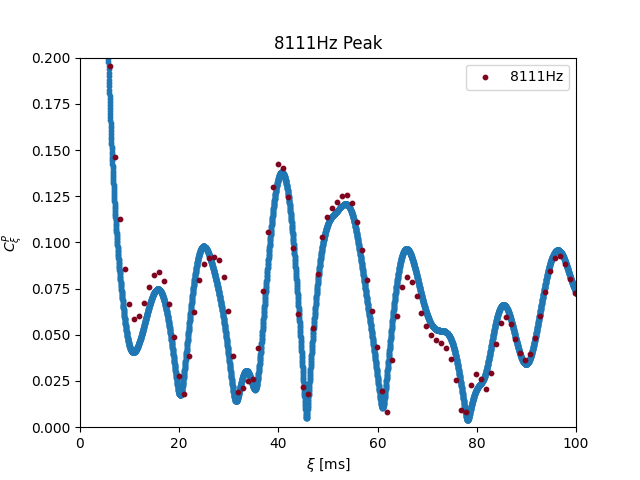

In [13]:
plt.close('all')
plt.figure()
plt.scatter(lags_ms[zero_lag_idx:], acf_norm[zero_lag_idx:], s=10)
N_xi, N_xi_dict = pc.get_N_xi(cgram_dict, f0)
pc.plot_N_xi_fit(N_xi_dict, plot_noise_floor=False, plot_fit=False)
plt.xlim(0, 100)
plt.ylim(0, 0.2)
plt.show()

[43323 43367 43411 43455 43499 43543 43587 43631 43675 43719 43763 43807
 43851 43895 43939 43983 44027 44071 44115 44159 44203 44247 44291 44335
 44379 44423 44467 44511 44555 44599 44643 44687 44731 44775 44819 44863
 44907 44951 44995 45039 45083 45127 45171 45215 45259 45303 45347 45391
 45435 45479 45523 45567 45611 45655 45699 45743 45787 45831 45875 45919
 45963 46007 46051 46095 46139 46183 46227 46271 46315 46359 46403 46447
 46491 46535 46579 46623 46667 46711 46755 46799 46843 46887 46931 46975
 47019 47063 47107 47151 47195 47239 47283 47327 47371 47415 47459 47503
 47547 47591 47635 47679]


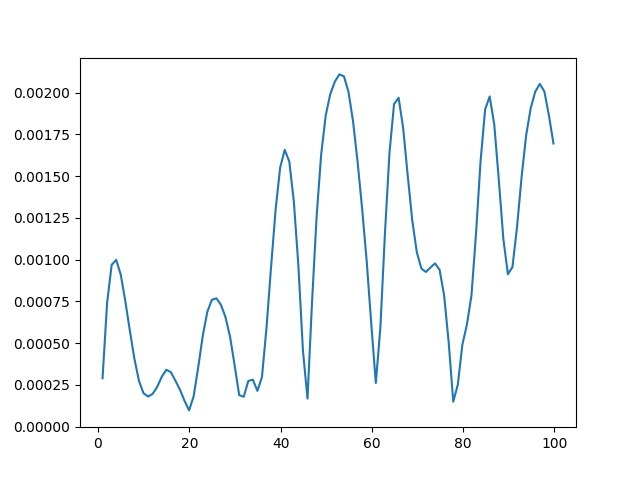

In [ ]:
plt.close('all')
plt.figure()
cgram_slice = N_xi_dict['colossogram_slice']
xis_ms = N_xi_dict['xis_s'] * 1000
# pos_lags_ms, pos_acf_norm = lags_ms[zero_lag_idx:zero_lag_idx + len(xis_ms)], acf_norm[zero_lag_idx:zero_lag_idx + len(xis_ms)]
selected_lag_idxs = np.argmin(np.abs(xis_ms[:, None] - lags_ms[None, :]), axis=1)
diff = acf_norm[selected_lag_idxs] - cgram_slice
plt.plot(xis_ms, diff)
plt.show()

# Small discrepancy is likely because we divide by the variance estimate Pxx which varies with xi (different number of segs) rather than the explicit variance of the whole waveform

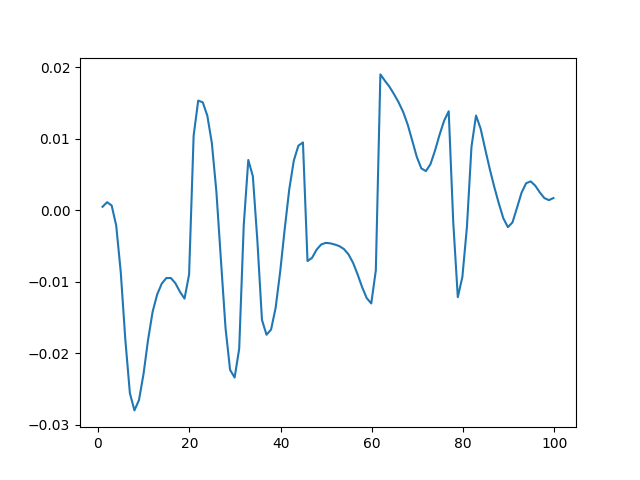

In [14]:
plt.close('all')
plt.figure()
cgram_slice = N_xi_dict['colossogram_slice']
xis_ms = N_xi_dict['xis_s'] * 1000
# pos_lags_ms, pos_acf_norm = lags_ms[zero_lag_idx:zero_lag_idx + len(xis_ms)], acf_norm[zero_lag_idx:zero_lag_idx + len(xis_ms)]
selected_lag_idxs = np.argmin(np.abs(xis_ms[:, None] - lags_ms[None, :]), axis=1)
diff = acf_norm[selected_lag_idxs] - cgram_slice
plt.plot(xis_ms, diff)
plt.show()

# Small discrepancy is likely because we divide by the variance estimate Pxx which varies with xi (different number of segs) rather than the explicit variance of the whole waveform